In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
mushra_file = "mushra_Test-20240227091558998516.csv"
data = pd.read_csv(mushra_file, sep=",", header=[1], parse_dates=True, skiprows=[2])
data = data.rename(columns={"Sound filename": "time"})

In [3]:
print(f"Number of data: {len(data)}")

Number of data: 21


In [4]:
raw_data = np.empty((2, 5, 5, len(data)))
time_spent = np.empty((2, 5, 5, len(data)))
test_numbers = [3, 4, 5, 6, 7, 8, 9, 11, 19, 24]
test_male = "p360"
test_female = "p361"
male_numbers = test_numbers[::2]
female_numbers = test_numbers[1::2]

model_names = ["gt", "golf", "world", "nhv", "pysptk"]

for i, j, k in np.ndindex(raw_data.shape[:3]):
    # normalize data from [0, 100] to [1, 5] likert scale
    raw_data[i, j, k] = data[
        f"{model_names[j]}_{test_male if i == 0 else test_female}_{test_numbers[i + k * 2]:03d}.wav"
    ].to_numpy()

mask = np.any(np.argmin(raw_data, axis=1) != 4, axis=(0, 1))
raw_data = raw_data[:, :, :, ~mask]
print(mask)

# normalisation
ranks = stats.rankdata(raw_data, axis=1)
# raw_data = ranks

raw_data = raw_data.reshape(2, 5, -1)

[False False False  True False False False  True False False  True False
 False False False  True False False False False False]


## Gender distribution

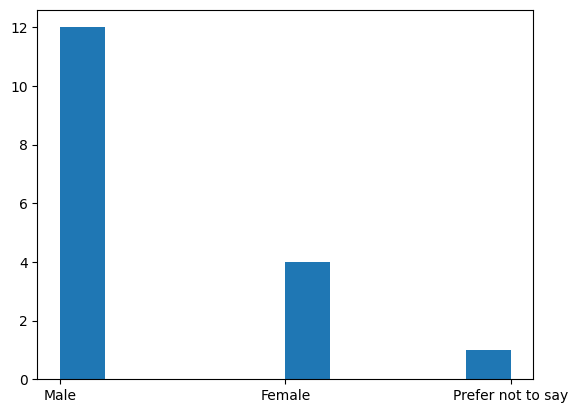

In [5]:
genders = data.loc[~mask, "Unnamed: 6"]

plt.hist(genders)
plt.show()

## Age Distribution

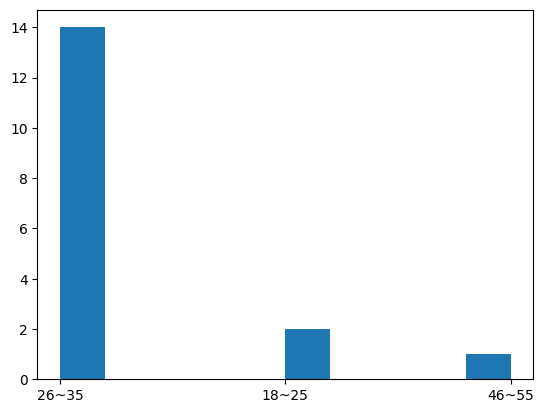

In [6]:
ages = data.loc[~mask, "Unnamed: 8"]

plt.hist(ages)
plt.show()

## Listening Devices

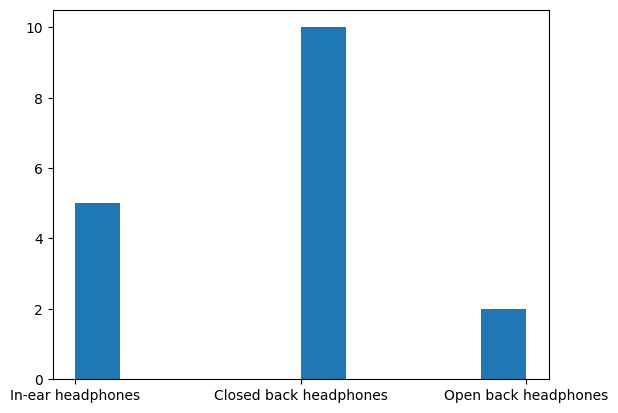

In [7]:
devices = data.loc[~mask, "Unnamed: 10"]

plt.hist(devices)
plt.show()

In [8]:
data.columns.where(data.columns.str.contains(".wav"))

Index([                 None,                  None,                  None,
                        None,                  None,                  None,
                        None,                  None,                  None,
                        None,                  None,                  None,
           'gt_p360_001.wav', 'pysptk_p360_001.wav',                  None,
                        None,                  None,     'gt_p360_003.wav',
        'world_p360_003.wav', 'pysptk_p360_003.wav',    'nhv_p360_003.wav',
         'golf_p360_003.wav',                  None,    'nhv_p360_005.wav',
       'pysptk_p360_005.wav',   'golf_p360_005.wav',     'gt_p360_005.wav',
        'world_p360_005.wav',                  None, 'pysptk_p360_007.wav',
          'nhv_p360_007.wav',   'golf_p360_007.wav',  'world_p360_007.wav',
           'gt_p360_007.wav',                  None, 'pysptk_p360_009.wav',
           'gt_p360_009.wav',   'golf_p360_009.wav',  'world_p360_009.wav',
          'n

[[88.68235294 58.52941176 44.52941176 37.62352941  6.51764706]
 [86.84705882 46.89411765 46.83529412 37.23529412  8.63529412]] [[2.65150639 3.87094237 3.858009   3.10652532 0.95943094]
 [2.49707063 3.74278497 4.12873333 3.18823523 1.30800536]] (2, 5, 85)


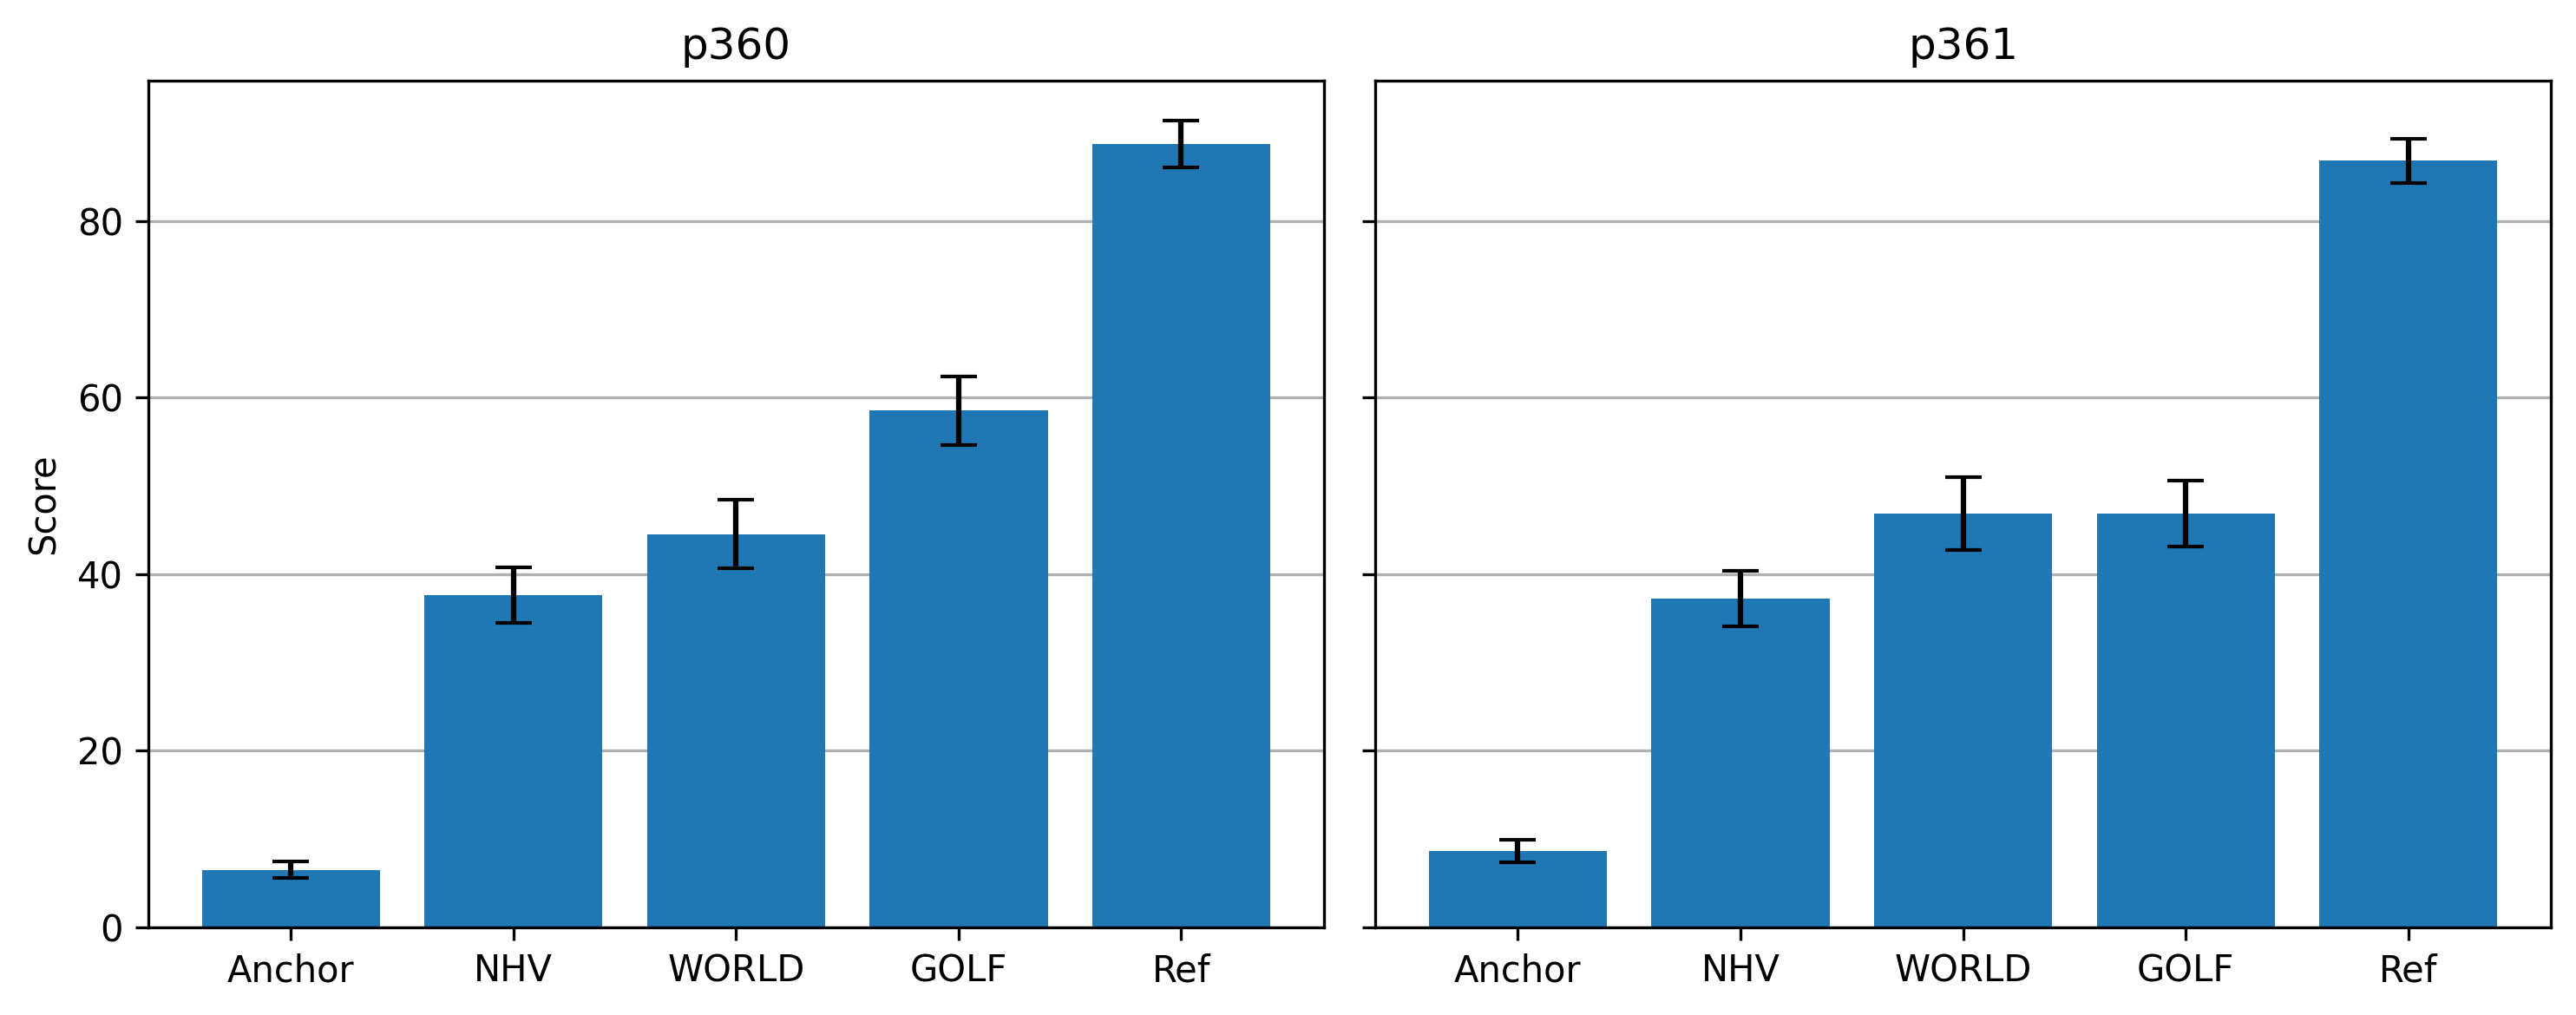

In [9]:
# using the last axis as the likert scale, calculate the MOS mean and 95% confidence interval
mos_mean = np.mean(raw_data, axis=-1)
mos_std = np.std(raw_data, axis=-1)
mos_ci = 1.96 * mos_std / np.sqrt(raw_data.shape[-1])

print(mos_mean, mos_ci, raw_data.shape)
sort_idx = np.argsort(mos_mean.mean(axis=0))
plt_names = [model_names[i] for i in sort_idx]
plt_mean = mos_mean[:, sort_idx]
plt_ci = mos_ci[:, sort_idx]

display_dict = {
    "gt": "Ref",
    "world": "WORLD",
    "nhv": "NHV",
    "golf": "GOLF",
    "pysptk": "Anchor",
}

# plot the result using different color for each likert scale
# sort the data by the mean of the first likert scale
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, dpi=300)
# plt.rc("axes", titlesize=24)
# plt.rc('axes', labelsize=20)
# plt.rc('ytick', labelsize=16)
# plt.rc('xtick', labelsize=18)
for i in range(2):
    ax[i].bar([display_dict[x] for x in plt_names], plt_mean[i], yerr=plt_ci[i],  align='center', ecolor='black', capsize=5)
    ax[i].set_title(f"{test_male if i == 0 else test_female}")

    if i == 0:
        ax[i].set_ylabel("Score")
    # ax[i].set_xlabel("Models")
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
# ax[0].set_ylim(ymin=0, ymax=5)
plt.tight_layout()
plt.show()

## ANOVA

## Paired t-test

In [10]:
print(stats.ttest_rel(raw_data[0, 2], raw_data[0, 3]))
print(stats.ttest_rel(raw_data[1, 0], raw_data[1, 1]))

TtestResult(statistic=3.9817957153264736, pvalue=0.0001448040295741036, df=84)
TtestResult(statistic=18.58750540785505, pvalue=1.6596660204178124e-31, df=84)


## Wilcoxon

In [11]:
print(stats.wilcoxon(raw_data[0, 1], raw_data[0, 2], alternative="greater"))
print(stats.wilcoxon(raw_data[1, 1], raw_data[1, 3], alternative="greater"))

WilcoxonResult(statistic=2990.0, pvalue=3.813951668653372e-08)
WilcoxonResult(statistic=2472.0, pvalue=1.7385703476595976e-06)
